# Propuesta Proyecto RecSys: Recomendación Grupal de Juegos de Mesa (setup)

Link de dataset: https://www.kaggle.com/datasets/threnjen/board-games-database-from-boardgamegeek?select=games.csv

In [1]:
# Si se ejecuta por primera vez, descomentar esta línea para instalar las dependencias
#!pip install -q kaggle
#!pip install pyreclab
#!pip install implicit
#!pip install surprise
#!pip install elliot
#!pip install kagglehub

Tutorial usado: https://www.kaggle.com/discussions/general/74235

Tutorial adicional usado: https://www.youtube.com/watch?v=yEXkEUqK52Q

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("threnjen/board-games-database-from-boardgamegeek")

print("Path to dataset files:", path)

/home/nico/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/nico/.cache/kagglehub/datasets/threnjen/board-games-database-from-boardgamegeek/versions/4


Arriba de esto aparecerá un "path to dataset files", ese path se debe copiar y pegar en la línea de abajo:

In [3]:
path_to_dataset_files = path
#path_to_dataset_files = '/home/nico/.cache/kagglehub/datasets/threnjen/board-games-database-from-boardgamegeek/versions/4'
#path_to_dataset_files = '/root/.cache/kagglehub/datasets/threnjen/board-games-database-from-boardgamegeek/versions/4'

import os
# Guardamos el directorio actual
base_dir = os.getcwd()
# Cambiamos al directorio donde se encuentra el dataset
os.chdir(path_to_dataset_files)

# Importamos las librerias
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import pyreclab
import tempfile
import implicit
import random
from surprise import accuracy

from abc import ABC, abstractmethod
import random

Generamos los datos a utilizar como un muestreo del dataset original pues es muy grande

In [4]:
# Leemos el csv y volvemos al directorio base del proyecto
user_ratings = pd.read_csv('user_ratings.csv')
mechanics_df = pd.read_csv('mechanics.csv')

# Volvemos al directorio base del proyecto
os.chdir(base_dir)

# Cambiamos username por un userid
a=list(set(list(user_ratings.Username)))
d = {a[i]: i for i in range(len(a))}
a_mod = [d[i] for i in list(user_ratings.Username)]
user_ratings["Username"] = a_mod

In [5]:
user_ratings = user_ratings.drop_duplicates(subset=['Username', 'BGGId'], keep='last')

Definimos parametros, sampleamos reviews solo de algunos items y eliminamos usuarios con una sola review

In [6]:
n_items = 1500
seed    = 3633
np.random.seed(seed)

i=np.array(list(set(user_ratings.BGGId)))
i_sample = np.random.choice(i, size=n_items, replace=False)

aux = user_ratings.groupby(by=["Username"]).count()
user_ratings = user_ratings[user_ratings.Username.isin(aux[aux.Rating > 1].index)]

# Sampling

In [7]:
""""
Forma original, solo se hace un sample de usuarios aleatorios
y con subconjuntos disjuntos para training y testing
"""

# # Separamos training y testing
# train     = list(set(user_ratings.Username))[:8000]
# test      = list(set(user_ratings.Username))[8000:11000]
# test_set  = user_ratings[user_ratings["Username"].isin(test)].sample(n=9000, random_state=seed)
# train_set = user_ratings[user_ratings["Username"].isin(train)].sample(n=35000, random_state=seed)

# # Generamos nuevo csv de training y testing
# train_set.to_csv("train.csv", index=False, sep=',', header=True)
# test_set.to_csv("test.csv", index=False, sep=',', header=True)

""""
Sample de usuarios solo de los items sampleados en la celda anterior
"""

# # Sacamos las reviews de los items sampleados
# user_ratings = user_ratings[user_ratings.BGGId.isin(i_sample)]

# # Separamos training y testing
# test_set  = user_ratings.sample(n=9000, random_state=seed)
# train_set = user_ratings.sample(n=35000, random_state=seed)

# # Generamos nuevo csv de training y testing
# train_set.to_csv("train.csv", index=False, sep=',', header=True)
# test_set.to_csv("test.csv", index=False, sep=',', header=True)

""""
Acá tomamos un conjunto de juegos populares, uno de mediana popularidad y
uno de baja popularidad, considerando popular a un juego con mayor número
de reseñas
"""

# Sample de items
aux_count_revs = user_ratings.groupby(by=["BGGId"]).count()
max_pop = aux_count_revs[aux_count_revs.Username > 900].sample(n=n_items//4, random_state=seed).index
high_pop = aux_count_revs[(aux_count_revs.Username > 250) & (aux_count_revs.Username <= 900)].sample(n=n_items//4, random_state=seed).index
mid_pop = aux_count_revs[(aux_count_revs.Username > 80) & (aux_count_revs.Username <= 250)].sample(n=n_items//4, random_state=seed).index
low_pop = aux_count_revs[(aux_count_revs.Username > 40) & (aux_count_revs.Username <= 80)].sample(n=n_items//4, random_state=seed).index
selected = low_pop.union(mid_pop.union(high_pop.union(max_pop)))
user_ratings_sampleado = user_ratings[user_ratings.BGGId.isin(selected)]

Eliminamos reviews de usuarios con 3 o menos reviews

In [8]:
aux = user_ratings_sampleado.groupby(by=["Username"]).count()
user_ratings_sampleado = user_ratings_sampleado[user_ratings.Username.isin(aux[aux.Rating > 3].index)]

/tmp/ipykernel_21201/540523199.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_ratings_sampleado = user_ratings_sampleado[user_ratings.Username.isin(aux[aux.Rating > 3].index)]


## Sampling de usuarios

In [9]:
user_review_counts = user_ratings_sampleado.groupby('Username').size()

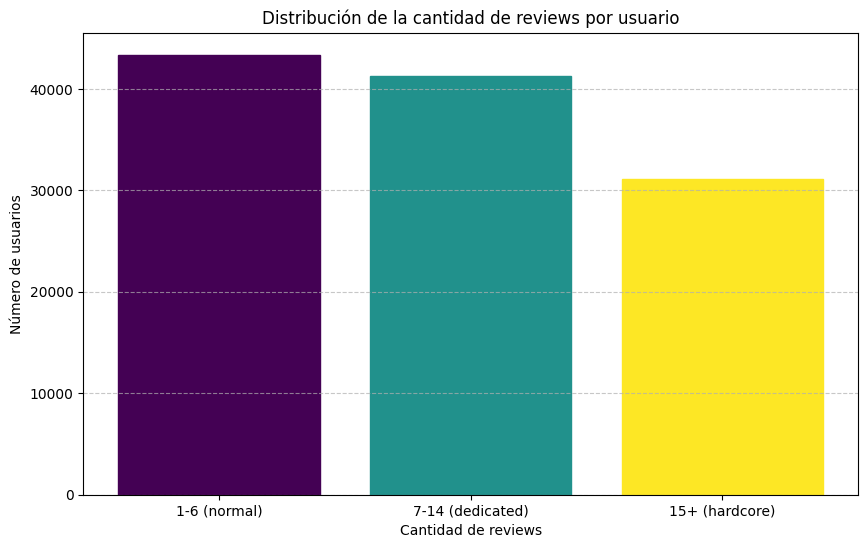

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Crear un gráfico de barras para usuarios
plt.figure(figsize=(10, 6))
bins = [2, 7, 15, np.inf]
counts, _ = np.histogram(user_review_counts, bins=bins)
categories = ['1-6 (normal)', '7-14 (dedicated)', '15+ (hardcore)']
bars = plt.bar(categories, counts, edgecolor='black')

# Aplicar gradiente de azul a verde
for bar, color in zip(bars, plt.cm.viridis(np.linspace(0, 1, len(bars)))):
    bar.set_color(color)

plt.title('Distribución de la cantidad de reviews por usuario')
plt.xlabel('Cantidad de reviews')
plt.ylabel('Número de usuarios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
n_users = 15000

aux_count_revs = user_ratings_sampleado.groupby(by=["Username"]).count()
high_pop = aux_count_revs[(aux_count_revs.BGGId > 14) & (aux_count_revs.BGGId <= 100)].sample(n=n_users//3, random_state=seed).index
# Nota: se eliminan usuarios con más de 200 reviews para asignar más recursos a usuarios con números de reviews más normales
mid_pop = aux_count_revs[(aux_count_revs.BGGId > 6) & (aux_count_revs.BGGId <= 14)].sample(n=n_users//3, random_state=seed).index
low_pop = aux_count_revs[(aux_count_revs.BGGId > 2) & (aux_count_revs.BGGId <= 6)].sample(n=n_users//3, random_state=seed).index
selected = low_pop.union(mid_pop.union(high_pop))
user_ratings_sampleando_usuarios = user_ratings_sampleado[user_ratings.Username.isin(selected)]

/tmp/ipykernel_21201/2850795242.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_ratings_sampleando_usuarios = user_ratings_sampleado[user_ratings.Username.isin(selected)]


Rehasheamos el dataset

In [12]:
user_ratings_sampleando_usuarios['Username'] = pd.factorize(user_ratings_sampleando_usuarios['Username'])[0]
user_ratings_sampleando_usuarios['BGGId'] = pd.factorize(user_ratings_sampleando_usuarios['BGGId'])[0]

/tmp/ipykernel_21201/3260538249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings_sampleando_usuarios['Username'] = pd.factorize(user_ratings_sampleando_usuarios['Username'])[0]
/tmp/ipykernel_21201/3260538249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings_sampleando_usuarios['BGGId'] = pd.factorize(user_ratings_sampleando_usuarios['BGGId'])[0]


Nos aseguramos de que el sampling tenga sentido

In [13]:
user_review_counts = user_ratings_sampleando_usuarios.groupby('Username').size()
user_review_counts.describe()

count    15000.00000
mean        14.78220
std         14.57415
min          4.00000
25%          6.00000
50%          9.00000
75%         18.00000
max        100.00000
dtype: float64

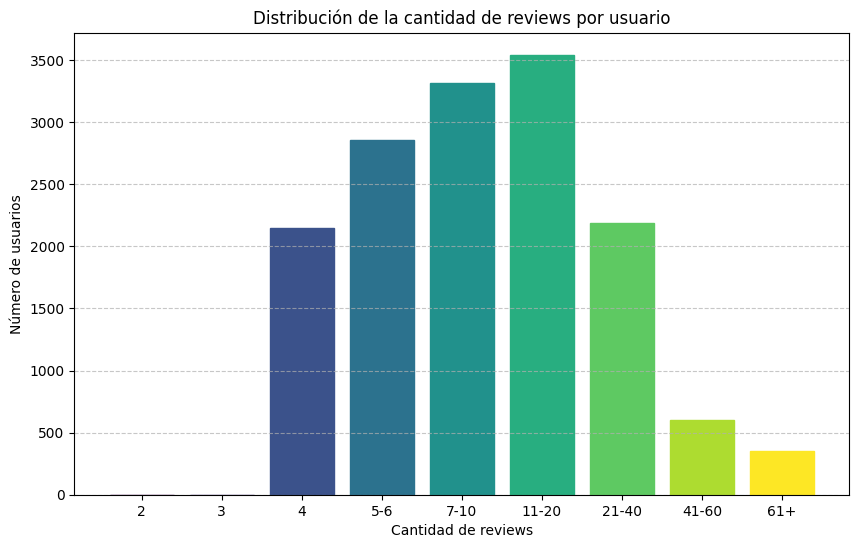

In [14]:
# Crear un gráfico de barras con categorías
plt.figure(figsize=(10, 6))
bins = [2, 3, 4, 5, 7, 11, 21, 41, 61, np.inf]
counts, _ = np.histogram(user_review_counts, bins=bins)
categories = ['2', '3', '4', '5-6', '7-10', '11-20', '21-40', '41-60', '61+']
bars = plt.bar(categories, counts, edgecolor='black')

# Aplicar gradiente de azul a verde
for bar, color in zip(bars, plt.cm.viridis(np.linspace(0, 1, len(bars)))):
    bar.set_color(color)

plt.title('Distribución de la cantidad de reviews por usuario')
plt.xlabel('Cantidad de reviews')
plt.ylabel('Número de usuarios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
game_review_counts = user_ratings_sampleando_usuarios.groupby('BGGId').size()
game_review_counts.describe()

count    1500.000000
mean      147.822000
std       407.730872
min         1.000000
25%        10.000000
50%        29.000000
75%       113.250000
max      5464.000000
dtype: float64

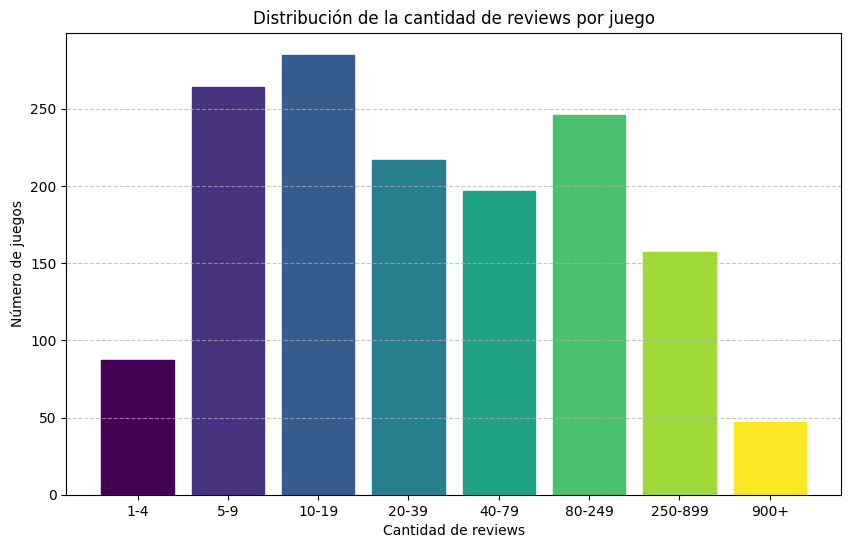

In [16]:

plt.figure(figsize=(10, 6))
bins = [0, 5, 10, 20, 40, 80, 250, 900, np.inf]
counts, _ = np.histogram(game_review_counts, bins=bins)
categories = ['1-4', '5-9', '10-19', '20-39', '40-79', '80-249', '250-899', '900+']
bars = plt.bar(categories, counts, edgecolor='black')

# Aplicar gradiente de azul a verde
for bar, color in zip(bars, plt.cm.viridis(np.linspace(0, 1, len(bars)))):
    bar.set_color(color)

plt.title('Distribución de la cantidad de reviews por juego')
plt.xlabel('Cantidad de reviews')
plt.ylabel('Número de juegos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
user_ratings_sampleando_usuarios.describe()

Generar datasets de entrenamiento y testeo

In [ ]:
# Separamos training y testing
test_set  = user_ratings_sampleando_usuarios.sample(frac=0.25, random_state=seed)
train_set = user_ratings_sampleando_usuarios.drop(test_set.index)

# Generamos nuevo csv de training y testing
train_set.to_csv("train.csv", index=False, sep=',', header=True)
test_set.to_csv("test.csv", index=False, sep=',', header=True)

# Creación de grupos

## Código importado

In [ ]:
# Groups generator from: https://github.com/barnap/group-recommenders-offline-evaluation/blob/main/synthetic_groups_generation/groups_generators.py

class GroupsGenerator(ABC):

    @staticmethod
    def getGroupsGenerator(type):
        if type == "RANDOM":
            return RandomGroupsGenerator()
        elif type == "SIMILAR":
            return SimilarGroupsGenerator()
        elif type == "DIVERGENT":
            return DivergentGroupsGenerator()
        elif type == "SIMILAR_ONE_DIVERGENT":
            return MinorityGroupsGenerator()
        return None

    @staticmethod
    def compute_average_similarity(group, user_id_indexes, sim_matrix):
        similarities = list()
        for user_1 in group:
            user_1_index = user_id_indexes.tolist().index(user_1)
            for user_2 in group:
                user_2_index = user_id_indexes.tolist().index(user_2)
                if user_1 != user_2:
                    similarities.append(sim_matrix[user_1_index][user_2_index])
        return np.mean(similarities)

    @abstractmethod
    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        pass


class RandomGroupsGenerator(GroupsGenerator):

    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        groups_list = list()
        for group_size in group_sizes_to_create:
            for i in range(group_number_to_create):
                group = random.sample(user_id_set, group_size)
                groups_list.append(
                    {
                        "group_size": group_size,
                        "group_similarity": 'random',
                        "group_members": group,
                        "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
                    }
                )
            print(len(groups_list))
        return groups_list


class SimilarGroupsGenerator(GroupsGenerator):

    @staticmethod
    def select_user_for_sim_group(group, sim_matrix, user_id_indexes, sim_threshold=0.4):
        '''
        Helper function to the generate_similar_user_groups function. Given already selected group members, it randomly
        selects from the remaining users that has a PCC value >= sim_threshold to any of the existing members.
        :param group:
        :param sim_matrix:
        :param user_id_indexes:
        :param sim_threshold:
        :return:
        '''
        ids_to_select_from = set()
        for member in group:
            member_index = user_id_indexes.tolist().index(member)
            indexes = np.where(sim_matrix[member_index] >= sim_threshold)[0].tolist()
            user_ids = [user_id_indexes[index] for index in indexes]
            ids_to_select_from = ids_to_select_from.union(set(user_ids))
        candidate_ids = ids_to_select_from.difference(set(group))
        if len(candidate_ids) == 0:
            return None
        else:
            selection = random.sample(candidate_ids, 1)
            return selection[0]

    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        groups_list = list()
        for group_size in group_sizes_to_create:
            groups_size_list = list()
            while (len(groups_size_list) < group_number_to_create):
                group = random.sample(user_id_set, 1)
                while len(group) < group_size:
                    new_member = SimilarGroupsGenerator.select_user_for_sim_group(group, similarity_matrix,
                                                                                  user_id_indexes,
                                                                                  sim_threshold=0.5)
                    if new_member is None:
                        break
                    group.append(new_member)
                if len(group) == group_size:
                    groups_size_list.append(
                        {
                            "group_size": group_size,
                            "group_similarity": 'similar',
                            "group_members": group,
                            "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
                        }
                    )
            groups_list.extend(groups_size_list)
            print(len(groups_list))
        return groups_list


class DivergentGroupsGenerator(GroupsGenerator):

    @staticmethod
    def select_user_for_divergent_group(group, sim_matrix, user_id_indexes, sim_threshold=0.0):
        '''
        Helper function to the generate_similar_user_groups function. Given already selected group members, it randomly
        selects from the remaining users that has a PCC value < sim_threshold to any of the existing members.
        :param group:
        :param sim_matrix:
        :param user_id_indexes:
        :param sim_threshold:
        :return:
        '''
        ids_to_select_from = set()
        for member in group:
            member_index = user_id_indexes.tolist().index(member)
            indexes = np.where(sim_matrix[member_index] < sim_threshold)[0].tolist()
            user_ids = [user_id_indexes[index] for index in indexes]
            ids_to_select_from = ids_to_select_from.union(set(user_ids))
        candidate_ids = ids_to_select_from.difference(set(group))
        if len(candidate_ids) == 0:
            return None
        else:
            selection = random.sample(candidate_ids, 1)
            return selection[0]

    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        groups_list = list()
        for group_size in group_sizes_to_create:
            groups_size_list = list()
            while (len(groups_size_list) < group_number_to_create):
                group = random.sample(user_id_set, 1)
                while len(group) < group_size:
                    new_member = DivergentGroupsGenerator.select_user_for_divergent_group(group, similarity_matrix,
                                                                                     user_id_indexes,
                                                                                     sim_threshold=-0.1)
                    if new_member is None:
                        break
                    group.append(new_member)
                if len(group) == group_size:
                    groups_size_list.append(
                        {
                            "group_size": group_size,
                            "group_similarity": 'divergent',
                            "group_members": group,
                            "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
                        }
                    )
            groups_list.extend(groups_size_list)
            print(len(groups_list))
        return groups_list


class MinorityGroupsGenerator(GroupsGenerator):
    def generateGroups(self, user_id_indexes, user_id_set, similarity_matrix, group_sizes_to_create, group_number_to_create):
        groups_list = list()
        for group_size in group_sizes_to_create:
            groups_size_list = list()
            while (len(groups_size_list) < group_number_to_create):
                group = random.sample(user_id_set, 1)
                while len(group) < (group_size - 1):
                    new_member = SimilarGroupsGenerator.select_user_for_sim_group(group, similarity_matrix,
                                                                                     user_id_indexes,
                                                                                     sim_threshold=0.5)
                    if new_member is None:
                        break
                    group.append(new_member)

                dissimilar_member = DivergentGroupsGenerator.select_user_for_divergent_group(group, similarity_matrix,
                                                                                              user_id_indexes,
                                                                                              sim_threshold=-0.1)
                if dissimilar_member is not None:
                    group.append(dissimilar_member)
                if len(group) == group_size:
                    groups_size_list.append(
                        {
                            "group_size": group_size,
                            "group_similarity": 'similar_one_divergent',
                            "group_members": group,
                            "avg_similarity": GroupsGenerator.compute_average_similarity(group, user_id_indexes, similarity_matrix)
                        }
                    )
            groups_list.extend(groups_size_list)
            print(len(groups_list))
        return groups_list

## Código nuestro

Informacion para crear grupos

In [ ]:
group_sizes_to_create = [4]        # [2, 3, 4, 5, 6, 7, 8]
group_similarity_to_create = "RANDOM"  # ["RANDOM", "SIMILAR"]
group_number = 10000

Creacion de los grupos

In [ ]:
# Extraccion de un sample para poder manejarlo
user_ratings = train_set.sample(5000)

# Informacion del dataset
user_matrix = user_ratings.pivot_table(columns='BGGId', index='Username', values='Rating')
user_id_set = set(user_ratings['Username'])
user_id_indexes = user_matrix.index.values
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)

#Creacion del generador
grpGenerator = GroupsGenerator.getGroupsGenerator(group_similarity_to_create)
grpList = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)

#display(pd.DataFrame.from_records(grpList))
pd.DataFrame.from_records(grpList).to_csv('synthetic_groups.csv', index=False)

# Evaluación de baselines para 1 usuario

In [ ]:
# Trabajaremos con un top 10
top_n = 10
test_set.head(top_n)

In [ ]:
# Revisemos el tamaño del dataset para asegurarnos de que tiene un tamaño trabajable:
print("Tamaño del dataset completo:", user_ratings.shape)
print("Tamaño del dataset de entrenamiento:", train_set.shape)
print("Tamaño del dataset de prueba:", test_set.shape)

In [ ]:
# Evaluamos SVD
mySVD = pyreclab.SVD(dataset='train.csv', dlmchar=b',', header=False, usercol=2, itemcol=0, ratingcol=1)
mySVD.train(factors=50, maxiter=80, lr=0.1, lamb=0.5)
_, maeSVD, rmseSVD = mySVD.test(input_file = 'test.csv', dlmchar = b',', header = False, usercol = 2, itemcol = 0, ratingcol = 1)
_, mapSVD, ndcgSVD = mySVD.testrec(input_file="test.csv", dlmchar=b',', header=False, usercol=2, itemcol=0, ratingcol=1, topn=top_n)

print(f"mae = {maeSVD} y rmse = {rmseSVD}")
print(f"map = {mapSVD} y ndcg = {ndcgSVD}")

In [ ]:
# Evaluamos Most Popular
myMP = pyreclab.MostPopular(dataset='train.csv', dlmchar=b',', header=False, usercol=2, itemcol=0, ratingcol=1)
myMP.train(progress=False)
_, mapMP, ndcgMP = myMP.testrec(input_file="test.csv", dlmchar=b',', header=False, usercol=2, itemcol=0, ratingcol=1, topn=top_n)

print(f"map = {mapMP} y ndcg = {ndcgMP}")

In [ ]:
# Evaluamos Random ratings
predictions = []

rating_scale = (1, 10)

for _, row in test_set.iterrows():
    itemId = row["BGGId"]; rating = row["Rating"]; userId = row["Username"]
    random_rating = random.uniform(rating_scale[0], rating_scale[1])
    predictions.append((userId, itemId, rating, random_rating, None))

accuracy.rmse(predictions)
accuracy.mae(predictions)


Nota: el resto se movió al jupyter BaselinesPyreclab.ipynb

# Recomendación multimodal para un usuario

Setup del metadata

In [ ]:
!pip install lightfm

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from PIL import Image
import requests
from io import BytesIO

In [ ]:

df = train_set
cols_with_id = {col: idx for idx, col in enumerate(mechanics_df.columns[1:])}

# Conjunto de features
item_styles = {}

for _, row in train_set.iterrows():
    bgg_id = row['BGGId']
    style_row = mechanics_df[mechanics_df['BGGId'] == bgg_id].drop(columns=['BGGId'])
    styles = style_row.columns[style_row.iloc[0] == 1].tolist()
    item_styles[bgg_id] = styles

print(item_styles)



itemslist = df['BGGId'].unique()
userslist = df['Username'].unique()
stylelist = [i for i in range(len(cols_with_id))]

In [ ]:
#Conjunto de features, pero numericos

item_styles_with_ids = {}
for item_id, styles in item_styles.items():
    style_ids = [cols_with_id[style] for style in styles]
    item_styles_with_ids[item_id] = style_ids
print(item_styles_with_ids)

In [ ]:
interactions = [(row['Username'], row['BGGId'], row['Rating']) for index, row in df.iterrows()]

In [ ]:
dataset = Dataset()
all_features = set(feature for features in item_styles.values() for feature in features)

dataset.fit(users=userslist, items=itemslist, item_features=all_features)

In [ ]:
(interactions_matrix, weights_matrix) = dataset.build_interactions(
    ((x[0], x[1], x[2]) for x in interactions)
)

item_features = dataset.build_item_features(
    ((item_id, features) for item_id, features in item_styles.items())
)
print(interactions_matrix)
# print(item_features)

In [ ]:
model = LightFM(no_components=30, loss='warp')
model.fit(interactions_matrix, item_features=item_features, epochs=10, num_threads=4)

In [ ]:
def recommend(model, dataset, user_ids, n_items=5):
    n_users, n_items_total = interactions_matrix.shape
    item_ids = np.arange(n_items_total)
    recommendations_per_user = {}

    for user_id in user_ids:
        scores = model.predict(user_id, item_ids, item_features=item_features)
        top_items = item_ids[np.argsort(-scores)][:n_items]
        item_mapping = dataset.mapping()[2]
        item_id_mapping = {v: k for k, v in item_mapping.items()}
        recommended_items = [item_id_mapping[item] for item in top_items]
        print(f"User {user_id} recommended items: {recommended_items}")
        recommendations_per_user[user_id] = recommended_items

    return recommendations_per_user


In [ ]:
train_precision = precision_at_k(model, interactions_matrix, item_features=item_features, k=5).mean()
train_recall = recall_at_k(model, interactions_matrix, item_features=item_features, k=5).mean()

print(f'Train precision at k: {train_precision}')
print(f'Train Recall: {train_recall}')

In [ ]:
recommendations_group = recommend(model, dataset, [1, 2, 3], n_items=1000)
print(type(userslist))
print(recommendations_group)


---
---

# Ponderación para grupos de usuarios con recomendaciones de metadata

In [ ]:
groups_df = pd.read_csv('synthetic_groups.csv')
groups_df.head()

Código adaptado de repositorio mencionado anteriormente, en este caso tomamos los items que en promedio son más preferidos para recomendarlos al grupo.

In [ ]:
def recommend_for_group(model, dataset, group_members, n_items=5):
    n_users, n_items_total = interactions_matrix.shape
    item_ids = np.arange(n_items_total)
    user_mapping = dataset.mapping()[0]

    group_scores = []
    for user_id in group_members:
        try:
            internal_user_id = user_mapping[user_id]
            scores = model.predict(internal_user_id, item_ids, item_features=item_features)
            group_scores.append(scores)
        except KeyError:
            continue
        except Exception:
            continue

    if not group_scores:
        return []

    average_scores = np.mean(group_scores, axis=0)
    top_items = item_ids[np.argsort(-average_scores)][:n_items]

    item_mapping = dataset.mapping()[2]
    item_id_mapping = {v: k for k, v in item_mapping.items()}
    recommended_items = [item_id_mapping[item] for item in top_items]

    return recommended_items

group_recommendations = []
for _, row in groups_df.iterrows():
    group_members = eval(row['group_members']) if isinstance(row['group_members'], str) else row['group_members']
    recommendations = recommend_for_group(model, dataset, group_members, n_items=10)
    group_recommendations.append({
        'group_members': group_members,
        'recommendations': recommendations
    })

recommendations_df = pd.DataFrame(group_recommendations)
recommendations_df.to_csv('group_recommendations.csv', index=False)

In [ ]:
def recommend_for_group_multiple_models(model_name, model, group_members, n_items=10, include_rated=False):
    """
    Generate recommendations for a group using different pyreclab models
    Following exact format of original recommend_for_group function
    """
    group_scores = []


    for user_id in group_members:
        print(f"Recomendacion para user {user_id}")
        try:
            ranking = model.recommend(str(user_id), n_items, include_rated)

            recommended_items = ranking
            group_scores.append(recommended_items)

        except Exception as e:
            print(f"Error getting recommendations for user {user_id}: {str(e)}")
            continue

    if not group_scores:
        return []

    item_counts = {}
    for user_recs in group_scores:
        for item in user_recs:
            item_counts[item] = item_counts.get(item, 0) + 1

    sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)
    recommendations = [int(item) for item, _ in sorted_items[:n_items]]

    return recommendations

models = {
    'SVD': mySVD,
    # 'UserKNN': myUserKnn,
    # 'ItemKNN': myItemKnn,
    'MostPopular': myMP
}

for model_name, model in models.items():
    print(f"\nGenerating recommendations using {model_name}...")
    group_recommendations = []

    for _, row in groups_df.head(1000).iterrows():
        group_members = ast.literal_eval(row['group_members']) if isinstance(row['group_members'], str) else row['group_members']
        recommendations = recommend_for_group_multiple_models(model_name, model, group_members, n_items=10)

        group_recommendations.append({
            'group_members': str(group_members),
            'recommendations': str(recommendations)
        })

    recommendations_df = pd.DataFrame(group_recommendations)
    recommendations_df.to_csv(f'{model_name.lower()}_group_recommendations.csv', index=False)
    print(f"Generated recommendations for {len(recommendations_df)} groups")
    print("Sample format:")
    print(recommendations_df.head(1))

In [ ]:
import ast
import numpy as np
import pandas as pd

def parse_group_data(groups_df):
    parsed_data = []

    for _, row in groups_df.head(30).iterrows():
        group_members = ast.literal_eval(row['group_members'])
        recommendations = ast.literal_eval(row['recommendations'])
        parsed_data.append((group_members, recommendations))

    print(f"\nTotal groups parsed: {len(parsed_data)}")
    return parsed_data

def calculate_relevance(train_df, user_id, item_id):
    rating = train_df[
        (train_df['Username'] == user_id) &
        (train_df['BGGId'] == item_id)
    ]['Rating']

    return rating.iloc[0] if not rating.empty else 0

def calculate_group_metrics(parsed_data, train_df, k=5, threshold=3.5):
    total_precision = 0
    total_recall = 0
    total_ndcg = 0
    total_relevance = 0
    total_groups = len(parsed_data)
    total_hits = 0
    total_possible_hits = 0
    all_group_sizes = []

    for i, (group_members, recommendations) in enumerate(parsed_data):
        print(f"\rProcessing Group {i+1}/{total_groups}", end="")
        recommended_items = recommendations[:k]
        group_relevance = []
        group_hits = 0
        for item_id in recommended_items:
            member_ratings = []
            for user_id in group_members:
                rating = calculate_relevance(train_df, user_id, item_id)
                if rating > 0:
                    member_ratings.append(rating)
                    group_hits += 1
                total_possible_hits += 1
            avg_rating = np.mean(member_ratings) if member_ratings else 0
            group_relevance.append(avg_rating)

        total_hits += group_hits

        binary_relevance = [1 if rel >= threshold else 0 for rel in group_relevance]

        total_relevant = 0
        unique_items = train_df['BGGId'].unique()
        for item_id in unique_items:
            member_ratings = []
            for user_id in group_members:
                rating = calculate_relevance(train_df, user_id, item_id)
                if rating > 0:
                    member_ratings.append(rating)
            avg_rating = np.mean(member_ratings) if member_ratings else 0
            if avg_rating >= threshold:
                total_relevant += 1

        precision = sum(binary_relevance) / k if k > 0 else 0
        recall = sum(binary_relevance) / total_relevant if total_relevant > 0 else 0

        dcg = sum((2 ** rel - 1) / np.log2(idx + 2)
                  for idx, rel in enumerate(group_relevance))
        ideal_relevance = sorted(group_relevance, reverse=True)
        idcg = sum((2 ** rel - 1) / np.log2(idx + 2)
                   for idx, rel in enumerate(ideal_relevance))
        ndcg = dcg / idcg if idcg > 0 else 0

        total_precision += precision
        total_recall += recall
        total_ndcg += ndcg
        total_relevance += np.mean(group_relevance) if group_relevance else 0

    avg_metrics = {
        "average_precision": total_precision / total_groups,
        "average_recall": total_recall / total_groups,
        "average_ndcg": total_ndcg / total_groups,
        "average_relevance": total_relevance / total_groups,
        # "hit_rate": total_hits / total_possible_hits,
        # "average_group_size": np.mean(all_group_sizes),
        # "total_groups": total_groups,
        # "total_hits": total_hits,
        # "total_possible_hits": total_possible_hits
    }

    return avg_metrics

### Item sample

#### Grupos aleatorios

In [ ]:
# most popular
test_df = pd.read_csv('recommendations/itemsample/item_sample_test.csv')
groups_df = pd.read_csv('recommendations/itemsample/item_sample_mostpopular_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# SVD
test_df = pd.read_csv('recommendations/itemsample/item_sample_test.csv')
groups_df = pd.read_csv('recommendations/itemsample/item_sample_svd_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# metadata
test_df = pd.read_csv('recommendations/itemsample/item_sample_test.csv')
groups_df = pd.read_csv('recommendations/itemsample/item_sample_svd_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

#### Grupos similares

In [ ]:
# most popular
test_df = pd.read_csv('recommendations/itemsample/item_sample_test.csv')
groups_df = pd.read_csv('recommendations/itemsample/item_sample_mostpopular_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# SVD
test_df = pd.read_csv('recommendations/itemsample/item_sample_test.csv')
groups_df = pd.read_csv('recommendations/itemsample/item_sample_svd_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# metadata
test_df = pd.read_csv('recommendations/itemsample/item_sample_test.csv')
groups_df = pd.read_csv('recommendations/itemsample/item_sample_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

### Last sample

#### Grupos aleatorios

In [ ]:
# most popular
test_df = pd.read_csv('recommendations/lastsample/last_sample_test.csv')
groups_df = pd.read_csv('recommendations/lastsample/last_sample_mostpopular_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# SVD
test_df = pd.read_csv('recommendations/lastsample/last_sample_test.csv')
groups_df = pd.read_csv('recommendations/lastsample/last_sample_svd_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# metadata
test_df = pd.read_csv('recommendations/lastsample/last_sample_test.csv')
groups_df = pd.read_csv('recommendations/lastsample/last_sample_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

#### Grupos similares

In [ ]:
# most popular
test_df = pd.read_csv('recommendations/lastsample/last_sample_test.csv')
groups_df = pd.read_csv('recommendations/lastsample/last_sample_mostpopular_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# SVD
test_df = pd.read_csv('recommendations/lastsample/last_sample_test.csv')
groups_df = pd.read_csv('recommendations/lastsample/last_sample_svd_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# metadata
test_df = pd.read_csv('recommendations/lastsample/last_sample_test.csv')
groups_df = pd.read_csv('recommendations/lastsample/last_sample_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

### Random Sample

#### Grupos Aleatorios

In [ ]:
# most popular
test_df = pd.read_csv('recommendations/randomsample/test.csv')
groups_df = pd.read_csv('recommendations/randomsample/mostpopular_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# SVD
test_df = pd.read_csv('recommendations/randomsample/test.csv')
groups_df = pd.read_csv('recommendations/randomsample/svd_random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# metadata
test_df = pd.read_csv('recommendations/randomsample/test.csv')
groups_df = pd.read_csv('recommendations/randomsample/random_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

#### Grupos similares

In [ ]:
# most popular
test_df = pd.read_csv('recommendations/randomsample/test.csv')
groups_df = pd.read_csv('recommendations/randomsample/mostpopular_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# SVD
test_df = pd.read_csv('recommendations/randomsample/test.csv')
groups_df = pd.read_csv('recommendations/randomsample/svd_similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

In [ ]:
# metadata
test_df = pd.read_csv('recommendations/randomsample/test.csv')
groups_df = pd.read_csv('recommendations/randomsample/similar_group_recommendations.csv')
parsed_data = parse_group_data(groups_df)
metrics = calculate_group_metrics(parsed_data, test_df, k=5)
print(f"Precision: {metrics['average_precision']:.3f}")
print(f"Recall: {metrics['average_recall']:.3f}")
print(f"nDCG: {metrics['average_ndcg']:.3f}")
print(f"Relevance Score: {metrics['average_relevance']:.2f}")

# Hasta aca esta probado

In [ ]:
# # New cell for AGREE implementation
# # New cell for AGREE implementation
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from ast import literal_eval
# from scipy import sparse

# # Model classes
# class UserEmbeddingLayer(nn.Module):
#     def __init__(self, num_users, embedding_dim):
#         super(UserEmbeddingLayer, self).__init__()
#         self.userEmbedding = nn.Embedding(num_users, embedding_dim)

#     def forward(self, user_inputs):
#         return self.userEmbedding(user_inputs)

# class ItemEmbeddingLayer(nn.Module):
#     def __init__(self, num_items, embedding_dim):
#         super(ItemEmbeddingLayer, self).__init__()
#         self.itemEmbedding = nn.Embedding(num_items, embedding_dim)

#     def forward(self, item_inputs):
#         return self.itemEmbedding(item_inputs)

# class GroupEmbeddingLayer(nn.Module):
#     def __init__(self, num_groups, embedding_dim):
#         super(GroupEmbeddingLayer, self).__init__()
#         self.groupEmbedding = nn.Embedding(num_groups, embedding_dim)

#     def forward(self, group_inputs):
#         return self.groupEmbedding(group_inputs)

# class AttentionLayer(nn.Module):
#     def __init__(self, embedding_dim, drop_ratio=0.1):
#         super(AttentionLayer, self).__init__()
#         self.linear = nn.Sequential(
#             nn.Linear(embedding_dim, 16),
#             nn.ReLU(),
#             nn.Dropout(drop_ratio),
#             nn.Linear(16, 1)
#         )

#     def forward(self, x):
#         out = self.linear(x)
#         weight = torch.softmax(out.view(1, -1), dim=1)
#         return weight

# class PredictLayer(nn.Module):
#     def __init__(self, embedding_dim, drop_ratio=0.1):
#         super(PredictLayer, self).__init__()
#         self.linear = nn.Sequential(
#             nn.Linear(embedding_dim, 8),
#             nn.ReLU(),
#             nn.Dropout(drop_ratio),
#             nn.Linear(8, 1)
#         )

#     def forward(self, x):
#         return self.linear(x)

# class AGREE(nn.Module):
#     def __init__(self, num_users, num_items, num_groups, embedding_dim, group_member_dict, drop_ratio=0.1):
#         super(AGREE, self).__init__()
#         self.userembeds = UserEmbeddingLayer(num_users, embedding_dim)
#         self.itemembeds = ItemEmbeddingLayer(num_items, embedding_dim)
#         self.groupembeds = GroupEmbeddingLayer(num_groups, embedding_dim)
#         self.attention = AttentionLayer(2 * embedding_dim, drop_ratio)
#         self.predictlayer = PredictLayer(3 * embedding_dim, drop_ratio)
#         self.group_member_dict = group_member_dict

#         # Initialize weights
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight)
#             if isinstance(m, nn.Embedding):
#                 nn.init.xavier_normal_(m.weight)

#     def forward(self, group_inputs, user_inputs, item_inputs):
#         if (group_inputs is not None) and (user_inputs is None):
#             return self.group_forward(group_inputs, item_inputs)
#         else:
#             return self.user_forward(user_inputs, item_inputs)

#     def group_forward(self, group_inputs, item_inputs):
#         group_embeds = torch.Tensor()
#         item_embeds_full = self.itemembeds(torch.LongTensor(item_inputs))

#         for i, j in zip(group_inputs, item_inputs):
#             members = self.group_member_dict[i.item()]
#             members_embeds = self.userembeds(torch.LongTensor(members))
#             items_numb = [j] * len(members)
#             item_embeds = self.itemembeds(torch.LongTensor(items_numb))

#             group_item_embeds = torch.cat((members_embeds, item_embeds), dim=1)
#             at_wt = self.attention(group_item_embeds)
#             g_embeds_with_attention = torch.matmul(at_wt, members_embeds)
#             group_embeds_pure = self.groupembeds(torch.LongTensor([i]))
#             g_embeds = g_embeds_with_attention + group_embeds_pure
#             group_embeds = torch.cat((group_embeds, g_embeds))

#         element_embeds = torch.mul(group_embeds, item_embeds_full)
#         new_embeds = torch.cat((element_embeds, group_embeds, item_embeds_full), dim=1)
#         return torch.sigmoid(self.predictlayer(new_embeds))

#     def user_forward(self, user_inputs, item_inputs):
#         user_embeds = self.userembeds(user_inputs)
#         item_embeds = self.itemembeds(item_inputs)
#         element_embeds = torch.mul(user_embeds, item_embeds)
#         new_embeds = torch.cat((element_embeds, user_embeds, item_embeds), dim=1)
#         return torch.sigmoid(self.predictlayer(new_embeds))

# # Load and prepare data
# groups_df = pd.read_csv('synthetic_groups.csv').iloc[:10000]
# groups_df['group_members'] = groups_df['group_members'].apply(literal_eval)

# # Convert sparse matrix to dense or CSR format for indexing
# if sparse.issparse(interactions_matrix):
#     interactions_matrix = interactions_matrix.tocsr()

# # Create mappings and initialize model
# all_users = set()
# for members in groups_df['group_members']:
#     all_users.update(members)

# user_to_idx = {old_id: idx for idx, old_id in enumerate(sorted(all_users))}
# item_to_idx = {old_id: idx for idx, old_id in enumerate(range(interactions_matrix.shape[1]))}
# group_member_dict = {
#     group_id: [user_to_idx[user] for user in members]
#     for group_id, members in enumerate(groups_df['group_members'])
# }

# # Initialize model
# embedding_dim = 32
# model = AGREE(
#     num_users=len(user_to_idx),
#     num_items=len(item_to_idx),
#     num_groups=len(groups_df),
#     embedding_dim=embedding_dim,
#     group_member_dict=group_member_dict
# )

# # Train model
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCELoss()

# print("Starting training...")
# for epoch in range(5):  # 5 epochs as example
#     model.train()
#     total_loss = 0

#     # Train on individual interactions
#     for user_idx in range(interactions_matrix.shape[0]):
#         # Get non-zero elements for this user
#         items = interactions_matrix[user_idx].nonzero()[1]

#         for item_idx in items:
#             user_tensor = torch.LongTensor([user_idx])
#             item_tensor = torch.LongTensor([item_idx])

#             prediction = model(None, user_tensor, item_tensor)
#             target = torch.FloatTensor([[1.0]])  # Changed to 2D tensor

#             loss = criterion(prediction, target)

#             # Negative sampling
#             neg_item_idx = np.random.randint(0, interactions_matrix.shape[1])
#             while interactions_matrix[user_idx, neg_item_idx] != 0:
#                 neg_item_idx = np.random.randint(0, interactions_matrix.shape[1])

#             neg_item_tensor = torch.LongTensor([neg_item_idx])
#             neg_prediction = model(None, user_tensor, neg_item_tensor)
#             neg_target = torch.FloatTensor([[0.0]])  # Changed to 2D tensor

#             loss += criterion(neg_prediction, neg_target)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#     print(f'Epoch {epoch+1}/5, Loss: {total_loss}')

# print("Training completed!")

# # Function to get recommendations for a group
# def get_group_recommendations(model, group_idx, num_items, top_k=10):
#     model.eval()
#     with torch.no_grad():
#         scores = []
#         group_tensor = torch.LongTensor([group_idx])

#         for item_idx in range(num_items):
#             item_tensor = torch.LongTensor([item_idx])
#             score = model(group_tensor, None, item_tensor)
#             scores.append((item_idx, score.item()))

#         # Get top-k recommendations
#         recommendations = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
#         return [item_idx for item_idx, _ in recommendations]

# # Get recommendations for first group
# group_idx = 0
# recommendations = get_group_recommendations(model, group_idx, interactions_matrix.shape[1])
# print(f"\nTop 10 recommendations for group {group_idx}:")
# print(recommendations)

# # Optional: Get recommendations for all groups
# print("\nGenerating recommendations for all groups...")
# all_group_recommendations = {}
# for group_idx in range(len(groups_df)):
#     recommendations = get_group_recommendations(model, group_idx, interactions_matrix.shape[1])
#     all_group_recommendations[group_idx] = recommendations
#     print(f"Group {group_idx}: {recommendations}")